# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')
indonesian_stopwords = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FRANCESCO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FRANCESCO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Dataset

In [3]:
DATASET_PATH = '../dataset'
DATASET_NAME = '/Twitter_Emotion_Dataset.csv'
WORD_EMBEDDING = '/Word2Vec_400dim.txt'
ACRONYM_DATASET = '/kamus_singkatan.csv'

In [4]:
df = pd.read_csv(DATASET_PATH + DATASET_NAME, delimiter=',', header = 0, names=['emotion', 'tweet'])

In [5]:
acr_df = pd.read_csv(DATASET_PATH + ACRONYM_DATASET, delimiter=';', header=None, names=['acronym', 'full_form'])

In [6]:
df.head()

,emotion,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


# Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  4401 non-null   object
 1   tweet    4401 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


In [8]:
df.isna().sum()

emotion    0
tweet      0
dtype: int64

In [9]:
df['emotion'].value_counts()

emotion
anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: count, dtype: int64

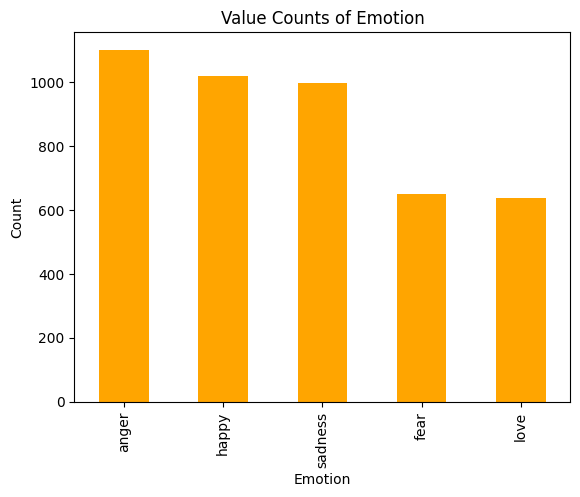

In [10]:
df['emotion'].value_counts().plot(kind = 'bar', color = 'orange')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Value Counts of Emotion')
plt.show()

## Character Count

In [11]:
df['char_count'] = df['tweet'].apply(lambda x: len(str(x)))
print('Anger: ' + str(df[df['emotion'] == 'anger']['char_count'].mean()))
print('Happy: ' + str(df[df['emotion'] == 'happy']['char_count'].mean()))
print('Sadness: ' + str(df[df['emotion'] == 'sadness']['char_count'].mean()))
print('Fear: ' + str(df[df['emotion'] == 'fear']['char_count'].mean()))
print('Love: ' + str(df[df['emotion'] == 'love']['char_count'].mean()))

Anger: 187.94822888283377
Happy: 178.26352015732547
Sadness: 180.75225677031094
Fear: 183.7904468412943
Love: 180.24960753532181


## Word Count

In [12]:
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
print('Anger: ' + str(df[df['emotion'] == 'anger']['word_count'].mean()))
print('Happy: ' + str(df[df['emotion'] == 'happy']['word_count'].mean()))
print('Sadness: ' + str(df[df['emotion'] == 'sadness']['word_count'].mean()))
print('Fear: ' + str(df[df['emotion'] == 'fear']['word_count'].mean()))
print('Love: ' + str(df[df['emotion'] == 'love']['word_count'].mean()))

Anger: 29.67665758401453
Happy: 27.388397246804328
Sadness: 28.60481444332999
Fear: 30.007704160246533
Love: 28.500784929356357


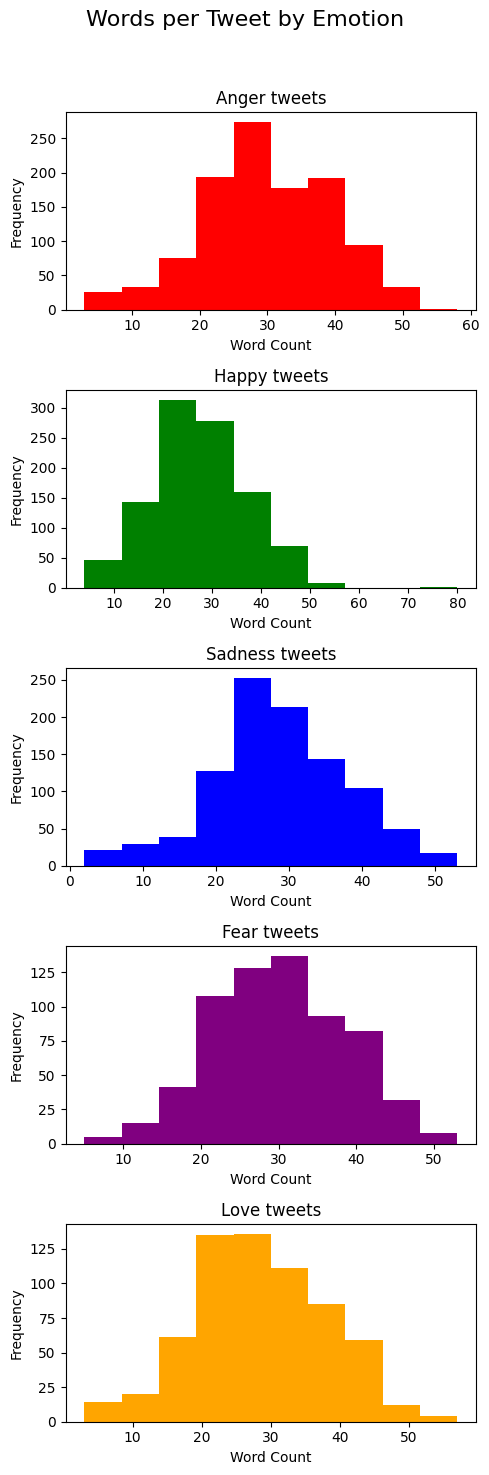

In [13]:
fig, axs = plt.subplots(5, 1, figsize=(5, 15))

emotions = ['anger', 'happy', 'sadness', 'fear', 'love']
colors = ['red', 'green', 'blue', 'purple', 'orange']

for ax, emotion, color in zip(axs, emotions, colors):
    train_words = df[df['emotion'] == emotion]['word_count']
    ax.hist(train_words, color=color)
    ax.set_title(f'{emotion.capitalize()} tweets')
    ax.set_xlabel('Word Count')
    ax.set_ylabel('Frequency')

fig.suptitle('Words per Tweet by Emotion', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()

# Preprocessing

## Replace Acronyms

In [14]:
acronym_dict = dict(zip(acr_df['acronym'], acr_df['full_form']))

In [15]:
def replace_acronyms(text, acronym_dict):
    words = text.split()
    words = [acronym_dict.get(word.upper(), word) for word in words]
    return ' '.join(words)

## Preprocess Text

In [16]:
def preprocess_text(text, acronym_dict):
    placeholders = [r'\[USERNAME\]', r'\[URL\]', r'\[SENSITIVE-NO\]']
    for placeholder in placeholders:
        text = re.sub(placeholder, '', text)

    text = replace_acronyms(text, acronym_dict)

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    words = word_tokenize(text)

    words = [word for word in words if word.lower() not in indonesian_stopwords]
    
    return ' '.join(words)

In [17]:
df['cleaned_tweet'] = df['tweet'].apply(lambda x: preprocess_text(x, acronym_dict))

## Emotional Encoding

In [18]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

In [19]:
X = df['cleaned_tweet']
y = pd.get_dummies(df['emotion_encoded']).values

## Word Embedding

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
max_sequence_length = max(len(x) for x in X_sequences)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [22]:
def load_word2vec_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [23]:
embeddings_index = load_word2vec_embeddings(DATASET_PATH + WORD_EMBEDDING)

In [24]:
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [25]:
embedding_dim = 400
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embeddings_index, embedding_dim)

In [26]:
def get_average_word2vec(tokens, embedding_matrix):
    vectors = [embedding_matrix[token] for token in tokens if token < embedding_matrix.shape[0]]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_matrix.shape[1])

In [27]:
X_embeddings = np.array([get_average_word2vec(seq, embedding_matrix) for seq in X_sequences])

In [28]:
y_int_encoded = df['emotion_encoded'].values

## Split Dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_int_encoded, test_size=0.2, random_state=42)

# Modeling

In [30]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.63      0.73      0.68       229
        fear       0.66      0.55      0.60       119
       happy       0.67      0.68      0.68       214
        love       0.74      0.72      0.73       119
     sadness       0.54      0.49      0.51       200

    accuracy                           0.64       881
   macro avg       0.65      0.64      0.64       881
weighted avg       0.64      0.64      0.64       881



# Validation

In [31]:
def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [32]:
emotion_labels = label_encoder.classes_

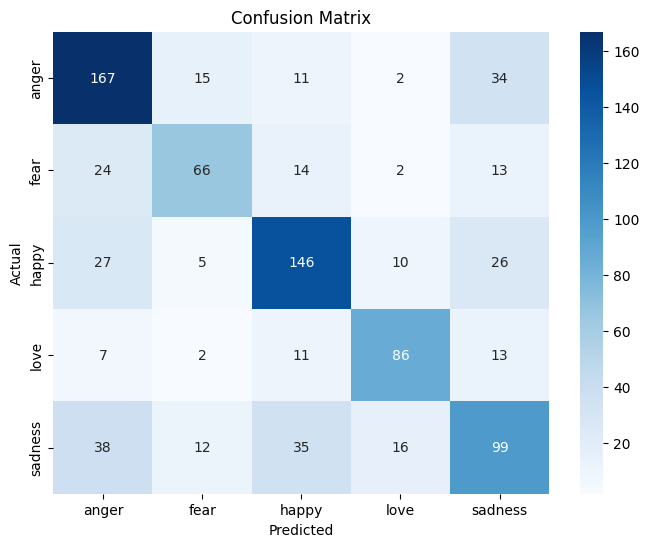

In [33]:
plot_confusion_matrix(y_test, y_pred_xgb, emotion_labels)